# **05.GBM**

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv('/content/features.txt', sep = '\s+', header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [59]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x.iloc[0]+'_'+str(x.iloc[1])if x.iloc[1]>0 else x.iloc[0], axis =1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis =1)
  return new_feature_name_df

In [60]:
def get_human_dataset():
  feature_name_df = pd.read_csv('/content/features.txt', sep = '\s+', header=None, names=['column_index', 'column_name'])

  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  # Assuming your actual training and testing data files are named 'X_train.txt', 'X_test.txt', 'y_train.txt', and 'y_test.txt'
  X_train = pd.read_csv('/content/X_train.txt', sep ='\s+', names = feature_name)
  X_test = pd.read_csv('/content/X_test.txt', sep = '\s+', names = feature_name)

  y_train = pd.read_csv('/content/y_train.txt', sep='\s+', header = None, names = ['action']).iloc[:, 0]
  y_test = pd.read_csv('/content/y_test.txt', sep='\s+', header = None, names = ['action']).iloc[:, 0]

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

#GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f}'.format(time.time() - start_time))

GBM 정확도: 0.9379
GBM 수행 시간: 1171.7


=> 앞서 랜덤 포레스트보다 나은 예측 성능
* but, 수행시간 오래걸림
* GradientBoostingClassifier는 약한 학습기의 순차적인 예측 오류 보정을 통해 학습을 수행하므로 멀티 CPU 코어 시스템을 사용하더라도 병렬 처리 지원되지 않아서 대용량 데이터의 경우 학습에 매우 많은 시간이 필요

# **06.XGBoost**

In [1]:
!pip install xgboost
!pip install pycaret[full]

In [2]:
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
import xgboost

print(xgboost.__version__)

3.0.5


# 위스콘신 유방암 예측-파이썬 래퍼 XGBoost 적용

In [4]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns = dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [5]:
print(dataset.target_names) #1이 양성 benign, 0이 악성 malignant
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [6]:
#cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
#맨 마지막 칼럼이 Label. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state=156)

#위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state =156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


**DMatrix**
* XGBoost만의 전용 데이터 객체인 DMatrix 사용
* Numpy 또는 Pandas로 돼 있는 학습용, 검증, 테스트용 데이터 세트를 모두 전용의 데이터 객체인 DMatrix로 생성해 모델에 입력해줘야함
* DataFrame과 Series 기반으로도 DMatrix 생성 가능

*주요 입력 파라미터: data(피처 데이터 세트)와 label(분류의 경우 데이터 세트, 회귀의 경우 숫자형인 종속값 데이터 세트)

In [7]:
#학습/검증/테스트용 DMatrix 생성
dtr = xgb.DMatrix(data = X_tr, label=y_tr)
dval = xgb.DMatrix(data = X_val, label=y_val)
dtest = xgb.DMatrix(data = X_test, label=y_test)

In [8]:
params = {'max_depth':3,
          'eta': 0.05,
          'objective': 'binary:logistic',
          'eval_metric':'logloss'
          }
num_rounds = 400

XGBoost 모델 학습시키기
* 파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train()함수에 파라미터로 전달(사이킷런의 경우는 Estimator의 생성자를 하이퍼 파라미터로 전달하는데 반해 차이 존재)
* 조기 중단: xgboost의 train()함수에 early_stopping_rounds 파라미터 입력
* 조기 중단 사용 시, 반드시 평가용 데이트 세트 지정과 eval_metric을 함께 설정
* Xgboost는 반복마다 지정된 평가용 데이터 세트에서 eval_metric의 지정된 평가지표로 예측 오류를 측정

* 평가용 데이터 세트는 학습과 평가용 데이터 세트를 명기하는 개별 튜플을 가지는 리스트 형태로 설정.
> ex) [(dtr, 'train'), (dval, 'eval')]
* 학습용 DMatrix는 'train'으로, 평가용 Dmatrix 'eval'로 개별 튜플에서 명기하여 설정
* eval_metric은 평가 세트에 적용할 성능평가 방법. 분류일 경우 주로 'error', 'logloss'를 적용


In [9]:
#학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기합니다.
eval_list = [(dtr, 'train'), (dval, 'eval')] #또는 eval_list = [(dval, 'eval')]만 명기해도 무방

#하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round = num_rounds, early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.62473	eval-logloss:0.63088
[1]	train-logloss:0.58662	eval-logloss:0.60461
[2]	train-logloss:0.55210	eval-logloss:0.58205
[3]	train-logloss:0.52068	eval-logloss:0.56165
[4]	train-logloss:0.49173	eval-logloss:0.54101
[5]	train-logloss:0.46517	eval-logloss:0.52206
[6]	train-logloss:0.44009	eval-logloss:0.50271
[7]	train-logloss:0.41646	eval-logloss:0.48606
[8]	train-logloss:0.39505	eval-logloss:0.46961
[9]	train-logloss:0.37523	eval-logloss:0.45485
[10]	train-logloss:0.35682	eval-logloss:0.44120
[11]	train-logloss:0.33964	eval-logloss:0.43123
[12]	train-logloss:0.32279	eval-logloss:0.41962
[13]	train-logloss:0.30783	eval-logloss:0.40848
[14]	train-logloss:0.29308	eval-logloss:0.39857
[15]	train-logloss:0.27928	eval-logloss:0.38945
[16]	train-logloss:0.26681	eval-logloss:0.38171
[17]	train-logloss:0.25498	eval-logloss:0.37381
[18]	train-logloss:0.24352	eval-logloss:0.36656
[19]	train-logloss:0.23307	eval-logloss:0.36014
[20]	train-logloss:0.22290	eval-logloss:0.35395
[2

=> 0~252까지만 실행(400번 채우지X), 203번째 반복에서 eval-logloss로 표기되는 검증데이터에 대한 logloss 값이 가장 낮음.
* 이후 252번까지 logloss 값이 향상되지 않았기에 멈춤

**테스트 데이터 세트에 예측 수행**

* 사이킷런의 predict() 메서드 => 예측 결과 클래스 값을 반환
* xgboost의 predict()는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환
* 예제-이진분류이므로 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값을 결정

In [10]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그러지 않으면 0으로 예측값 결정해 List 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.776 0.058 0.975 1.    0.999 0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [11]:
#get_eval_by_threshold, get_clf_eval 함수 정의
from sklearn.metrics import f1_score
from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba = None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도:{0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, f1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict =binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

In [12]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 2 75]]
정확도:0.9649, 정밀도: 0.9740, 재현율: 0.9740, f1: 0.9740, AUC:0.9965


**시각화 기능 수행**
* xgboost의 plot_importance() API: 피처 중요도를 막대그래프 형식으로 나타냄
* f스코어(해당 피처가 트리 분할 시 얼마나 자주 사용된건지를 나타낸 지표)를 기반
* plot_importance() 호출 시 파라미터로 앞에서 학습이 완료된 모델 객체 및 맷플롯립의 ax 객체를 입력
* 유의할점) xgboost를 DataFrame이 아닌 넘파이 기반의 피처 데이터로 학습 시에는 넘파이에서 피처명을 제대로 알 수 X.
* Y 축의 피처명을 나열 시 f0, f1과 같이 피처 순서별로 f자 뒤에 순서를 붙여서 피처명 나타냄


* 트리 기반 규칙 구조도 to_graphviz() API 이용하면 그릴 수 있음
* xgboost.to_graphviz() 내에 파라미터로 학습이 완료된 모델 객체와 Graphviz가 참조할 파일명을 입력해주면 됨

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

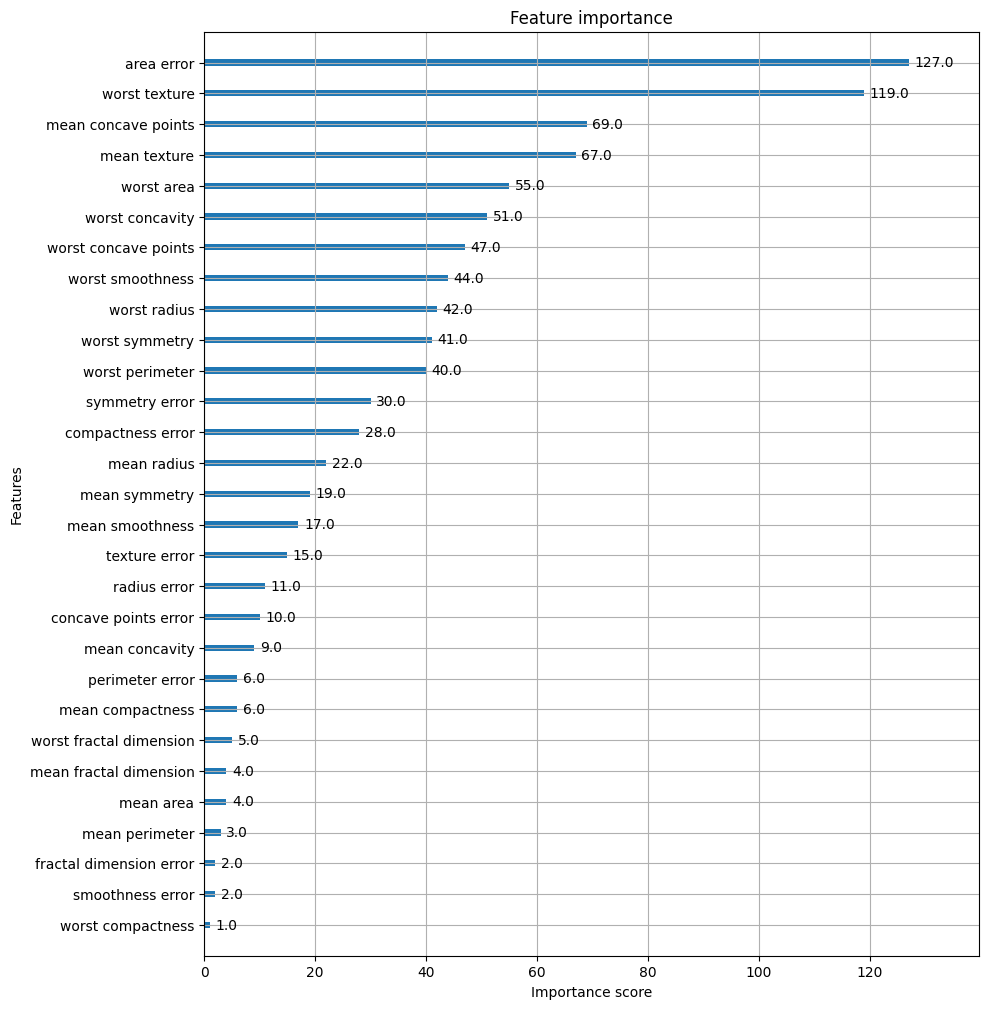

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)



**데이터 세트에 대한 교차검증 수행 후 최적 파라미터 구하기**
* cv() API 제공
* xgb.cv의 반환값은 DataFrame 형


```
xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(),obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbackes=None, shuffle=True)
```
* params(dict): 부스터 파라미터
* dtrain(DMatrix): 학습 데이터
* num_boost_round(int): 부스팅 반복 횟수
* nfold(int):CV 폴드 개수
* stratified(bool): CV 수행 시 층화 표본 추출(stratified sampling) 수행 여부
* metrics(string or list of strings): CV 수행 시 모니터링할 성능 평가 지표
* early_stopping_rounds (int): 조기 중단을 활성화시킴. 반복횟수 지정





**XGBClassifier를 이용해 유방암 데이터 세트 예측**


In [14]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

#Warning 메세지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력
xgb_wrappper = XGBClassifier(n_estimators= 400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrappper.fit(X_train, y_train, verbose = True)
w_preds = xgb_wrappper.predict(X_test)
w_pred_proba = xgb_wrappper.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도:0.9649, 정밀도: 0.9620, 재현율: 0.9870, f1: 0.9744, AUC:0.9951


**사이킷런 래퍼XGBoost에서 조기 중단 수행**
* early_stopping_rounds: 평가지표가 향상될 수 있는 반복 횟수를 정의
* eval_metric: 조기 중단을 위한 평가 지표
* eval_set: 성능 평가를 수행할 데이터 세트

In [16]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth=3, early_stopping_rounds=50, eval_metric ="logloss")
evals = [(X_tr, y_tr), (X_val,y_val)]
#fit 메서드에 early_stopping_rounds와 eval_metric 인자를 넣을 수 없음. 모델 인스턴스에 넣어야함
xgb_wrapper.fit(X_tr, y_tr, eval_set = evals, verbose = True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

In [17]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[35  2]
 [ 2 75]]
정확도:0.9649, 정밀도: 0.9740, 재현율: 0.9740, f1: 0.9740, AUC:0.9965


In [18]:
#early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper2 = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth=3, early_stopping_rounds=10, eval_metric ="logloss")
evals = [(X_tr, y_tr), (X_val,y_val)]
#fit 메서드에 early_stopping_rounds와 eval_metric 인자를 넣을 수 없음. 모델 인스턴스에 넣어야함
xgb_wrapper2.fit(X_tr, y_tr, eval_set = evals, verbose = True)

ws10_preds = xgb_wrapper2.predict(X_test)
ws10_pred_proba = xgb_wrapper2.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

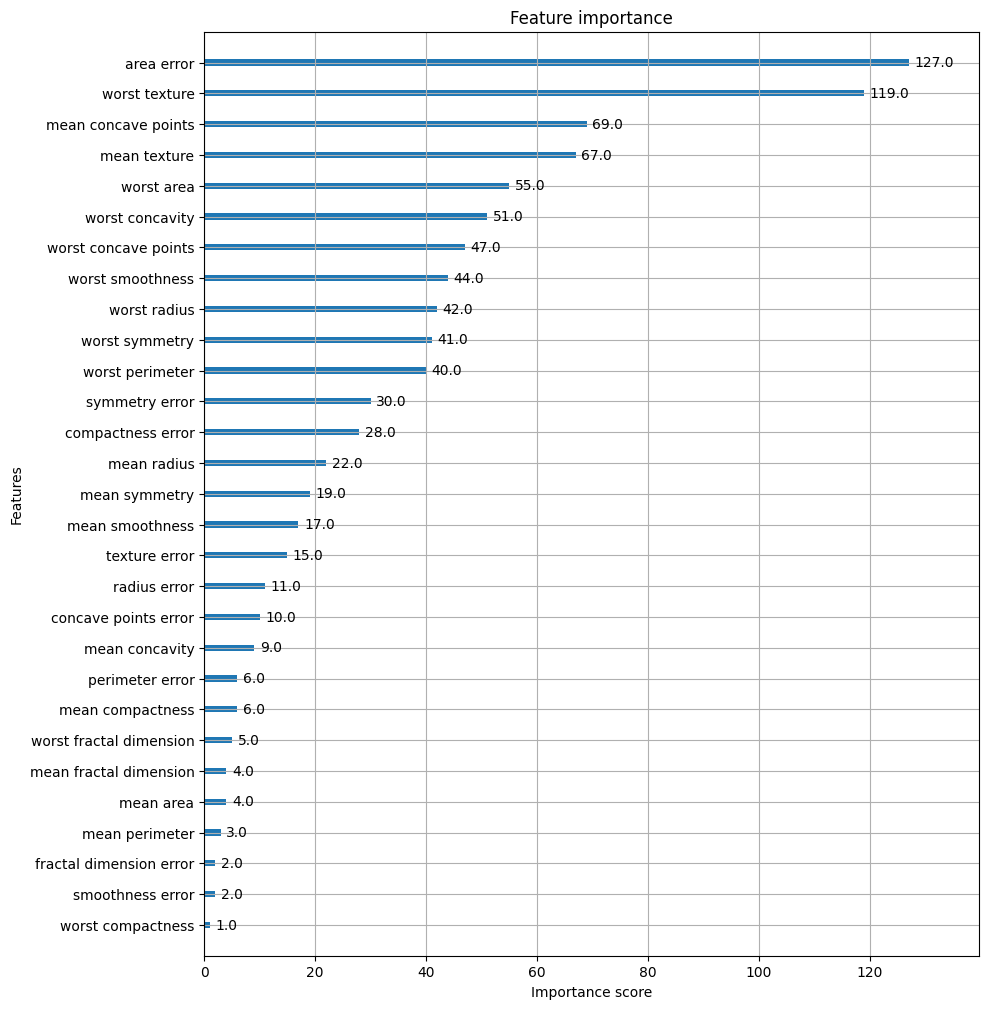

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
#사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax = ax)

# **07.LightGBM**

In [1]:
!pip install lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.4 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.6.0
    Uninstalling lightgbm-4.6.0:
      Successfully uninstalled lightgbm-4.6.0


In [2]:
import lightgbm
from lightgbm import LGBMClassifier

**LightGBM 적용-위스콘신 유방암 예측**
* LightGBM도 조기 중단이 가능

In [3]:
#LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

#데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state =156)

#위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습, 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

lgbm_wrapper = LGBMClassifier(n_estimators = 400, learning_rate = 0.05,  early_stopping_rounds=50, eval_metric='logloss')

evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, eval_set= evals)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_loglos

In [6]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도:0.9561, 정밀도: 0.9615, 재현율: 0.9740, f1: 0.9677, AUC:0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

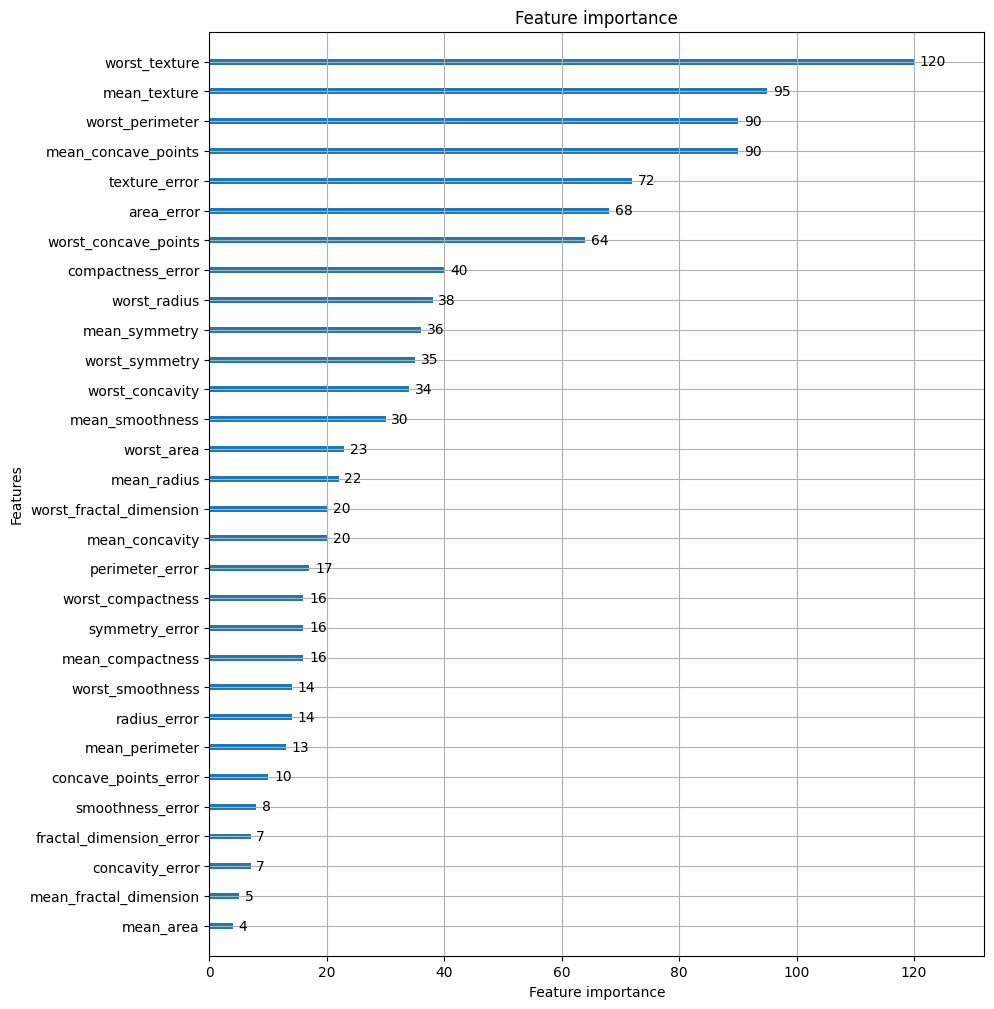

In [8]:
#plot_importance()
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm_wrapper, ax = ax)

# **08.베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝**



In [ ]:
!pip install hyperopt

HyperOpt의 hp모듈을 이용해 입력 변수명과 입력값의 검색 공간 설정
* 입력 변수명과 입력값 검색 공간은 파이썬 딕셔너리 형태로 설정돼야함
* key 값: 입력 변수명 // value: 해당 입력 변수의 검색 공간
* hp 모듈은 입력 값의 검색 공간을 다양하게 설정할 수 있도록 여러 가지 함수를 제공


```
hp.quniform('x', -10, 10, 1)
```

* 입력 변수 x는 -10부터 10까지 1의 간격을 가지는 값들.

In [20]:
from hyperopt import hp

#-10 ~10까지 1간격을 가지는 입력 변수 x와 -15~15까지 1 간격으로 입력 변수 y 설정
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1)}

low: 최솟값, high는 최댓값, q는 간격
* hp.quniform(label, low, high, q): label로 지정된 입력값 변수 검색 공간을 최솟값 low에서 최댓값 high까지 q의 간격을 가지고 설정.
* hp.uniform(label, low, high): 최솟값 low에서 최댓값 high까지 정규 분포 형태의 검색 공간 설정
* hp.randint(label, upper): 0부터 최댓값 upper까지 random한 정숫값으로 검색 공간 설정
* hp.loguniform(label, low, high): exp(uniform(low, high))값을 반환, 반환 값의 log 변환된 값은 정규 분포 형태를 가지는 검색 공간 설정
* hp.choice(label, options): 검색 값이 문자열 또는 문자열과 숫자값이 섞여 있을 경우 설정, Options는 리스트나 튜플 형태로 제공됨. hp.choice('tree_criterion',['gini', 'entropy'])과 같이 설정하면 입력 변수 tree_criterion의 값을 'gini'와 'entropy'로 설정하여 입력함.

목적 함수 생성
* 반드시 변숫값과 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환하는 구조로 만들어져야함

In [21]:
from hyperopt import STATUS_OK

#목적 함수를 생성, 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
  x = search_space['x']
  y = search_space['y']
  retval = x**2 - 20*y

  return retval

목적 함수의 반환값이 최소가 될 수 있는 최적의 입력값을 베이지안 최적화 기법에 기반하여 찾아줘야함


```
fmin(objective, space, algo, max_evals, trials)
```
함수 제공
* fn: 위에서 생성한 objective_func와 같은 목적함수
* space: 위에서 생성한 search_space와 같은 검색 공간 딕셔너리
* algo: 베이지안 최적화 적용 알고리즘. 기본적으로 tpe.suggest(HyperOpt의 기본 최적화 알고리즘은 TPE(Tree of Parzen Estimator)를 의미.
* max_evals: 최적 입력값을 찾기 위한 입력값 시도 횟수
* trials: 최적 입력값을 찾기 위해 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과를 저장하는데 사용. Trials 클래스를 객체로 생성한 변수명을 입력
* rstate: fmin()을 수행할 때마다 동일한 결괏값을 가질 수 있도록 설정하는 랜덤 시드(seed) 값. 일반적으로 잘 적용 안함,



In [ ]:
from hyperopt import fmin, tpe, Trials
import numpy as np
#입력 결괏값을 저장한 Trials 객체값 생성
trial_val = Trials()

#목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals = 5)로 찾아냄
best_01 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 5, trials =trial_val, rstate = np.random.default_rng(seed = 0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 621.42trial/s, best loss: -224.0]
best: {'x': np.float64(-4.0), 'y': np.float64(12.0)}


In [ ]:
trial_val = Trials()

#max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space = search_space, algo=tpe.suggest, max_evals=20, trials= trial_val, rstate = np.random.default_rng(seed = 0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 909.21trial/s, best loss: -296.0]
best: {'x': np.float64(2.0), 'y': np.float64(15.0)}


fmin() 함수 수행 시 인자로 들어가는 Trials 객체는 함수의 반복 수행 시마다 입력되는 변숫값들과 함수 반환값을 속성으로 가짐.
* 주요 속성: results, vals
* result : 함수의 반복 수행 시마다 반환되는 반환값 가짐.리스트 형태
* vals: 함수의 반복 수행 시마다 입력되는 입력 변숫값을 가짐.딕셔너리 형태

In [ ]:
#리스트 내부의 개별 원소는 {'loss': 함수 반환값, 'status': 반환 상태값}와 같은 딕셔너리
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [ ]:
#Trials 객체의 vals 속성에 {'입력변수명': 개별 수행 시마다 입력된 값 리스트} 형태로 저장됨
print(trial_val.vals)

{'x': [np.float64(-6.0), np.float64(-4.0), np.float64(4.0), np.float64(-4.0), np.float64(9.0), np.float64(2.0), np.float64(10.0), np.float64(-9.0), np.float64(-8.0), np.float64(-0.0), np.float64(-0.0), np.float64(1.0), np.float64(9.0), np.float64(6.0), np.float64(9.0), np.float64(2.0), np.float64(-2.0), np.float64(-4.0), np.float64(7.0), np.float64(-0.0)], 'y': [np.float64(5.0), np.float64(10.0), np.float64(-2.0), np.float64(12.0), np.float64(1.0), np.float64(15.0), np.float64(7.0), np.float64(-10.0), np.float64(0.0), np.float64(-5.0), np.float64(-3.0), np.float64(2.0), np.float64(4.0), np.float64(10.0), np.float64(3.0), np.float64(3.0), np.float64(-14.0), np.float64(-8.0), np.float64(11.0), np.float64(-0.0)]}


In [ ]:
import pandas as pd

#results에서 loss 키값에 해당하는 value 들을 추출해 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

#DataFrame으로 생성
result_df = pd.DataFrame({'x':trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


**HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화**

1.  적용할 하이퍼 파라미터와 검색 공간 설정
2. 목적 함수에서 XGBoost 학습 후 예측 성능 결과를 반환값으로 설정
3. fmin() 함수에서 목적 함수를 하이퍼 파라미터 검색 공간의 입력값들을 사용해 최적의 예측 성능 결과를 반환하는 최적 입력값들을 결정

주의할점
* 특정 하이퍼 파라미터들을 정숫값만 입력 받음. but, HyperOpt는 입력값과 반환값이 모두 실수형-> 하이퍼 파라미터 입력 시 형변환
* HyperOpt의 목적 함수는 최솟값을 반환할 수 있도록 최적화해야하기에 성능 값이 클수록 좋은 성능 지표일 경우 -1을 곱해줘야함

In [22]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_features = cancer.data
y_label = cancer.target

#위스콘신 유방안 데이터 세트
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=156)

In [23]:
from hyperopt import hp

#max_depth는 5에서 20까지 1간격, min_child_weight는 1에서 2까지 1간격
#colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1,2,1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

cross_val_score()를 XGBoost나 LightGBM에 적용할 경우 조기 중단이 지원되지 않음
* 조기 중단을 위해서는 KFold로 학습과 검증용 데이터 세트를 만들어서 직접 교차 검증을 수행해야함

In [24]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

def objective_func(search_space):
  #수행 시간 절약을 위해 nestimators는 100으로 축소
  xgb_clf = XGBClassifier(n_estimators= 100, max_depth=int(search_space['max_depth']),
                          min_child_weight = int(search_space['min_child_weight']),
                          learning_rate = search_space['learning_rate'],
                          colsample_bytree = search_space['colsample_bytree'],
                          eval_metric='logloss'
                          )
  accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring = 'accuracy', cv=3)
  return {'loss': -1*np.mean(accuracy), 'status': STATUS_OK}




In [ ]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space = xgb_search_space,
            algo= tpe.suggest,
            max_evals = 50,
            trials = trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best)

100%|██████████| 50/50 [00:19<00:00,  2.57trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': np.float64(0.6921910039842749), 'learning_rate': np.float64(0.15522232699479022), 'max_depth': np.float64(5.0), 'min_child_weight': np.float64(2.0)}


In [ ]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(round(best['colsample_bytree'],5),
                                                                                            round(best['learning_rate'],5),
                                                                                            int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.69219, learning_rate:0.15522, max_depth:5, min_child_weight:2


In [ ]:
#최적 하이퍼 파라미터들로 재학습
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate = round(best['learning_rate'], 5),
                            max_depth = int(best['max_depth']),
                            min_child_weight = int(best['min_child_weight']),
                            colsample_bytree= round(best['colsample_bytree'],5),
                            early_stopping_rounds = 50, eval_metric = 'logloss',
                            )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.54702	validation_1-logloss:0.58306
[1]	validation_0-logloss:0.45537	validation_1-logloss:0.52828
[2]	validation_0-logloss:0.38488	validation_1-logloss:0.47419
[3]	validation_0-logloss:0.32925	validation_1-logloss:0.43037
[4]	validation_0-logloss:0.28461	validation_1-logloss:0.39378
[5]	validation_0-logloss:0.24923	validation_1-logloss:0.36709
[6]	validation_0-logloss:0.21855	validation_1-logloss:0.35207
[7]	validation_0-logloss:0.19418	validation_1-logloss:0.33183
[8]	validation_0-logloss:0.17292	validation_1-logloss:0.32125
[9]	validation_0-logloss:0.15573	validation_1-logloss:0.31447
[10]	validation_0-logloss:0.14006	validation_1-logloss:0.30507
[11]	validation_0-logloss:0.12748	validation_1-logloss:0.29375
[12]	validation_0-logloss:0.11520	validation_1-logloss:0.28846
[13]	validation_0-logloss:0.10569	validation_1-logloss:0.28031
[14]	validation_0-logloss:0.09665	validation_1-logloss:0.27171
[15]	validation_0-logloss:0.08859	validation_1-logloss:0.26808
[1

# **10. 분류 실습 - 캐글 신용카드 사기 검출**
**언더 샘플링과 오버 샘플링**
* 오버 샘플링의 SMOTE를 구현한 대표적인 파이썬 패키지는 imbalanced-learn

In [13]:
!pip install -U imbalanced-learn

In [27]:
from io import IncrementalNewlineDecoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


feature 의미
* Amount: 신용카드 트랜잭션 금액
* Class: 레이블로서 0의 경우 정상, 1의 경우 사기 트랜잭션


In [28]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [25]:
from sklearn.model_selection import train_test_split

#인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis = 1, inplace = True)
  return df_copy

In [29]:
#사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
  #인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  #DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [23]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   57    91]]
정확도:0.9992, 정밀도: 0.8750, 재현율: 0.6149, f1: 0.7222, AUC:0.9735


In [24]:
#학습/예측/평가 함수
def get_model_train_eval(model, ftr_train=None, ftr_test = None, tgt_train=None, tgt_test = None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

데이터 세트가 불균형한 레이블 값 분포도 가짐-> LGBMClassifier 객체 생성 시 boost_from_average = False 파라미터로 설정
(default = True)
* 불균형한 분포를 이루는 데이터에서 boost_from_average = True이면 재현률 및 ROC-AUC 성능 크게 저하

In [11]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs =-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, tgt_train = y_train, tgt_test=y_test)

오차 행렬
[[33  4]
 [ 1 76]]
정확도:0.9561, 정밀도: 0.9500, 재현율: 0.9870, f1: 0.9682, AUC:0.9933


**데이터 분포도 변환 후 모델 학습/예측/평가**

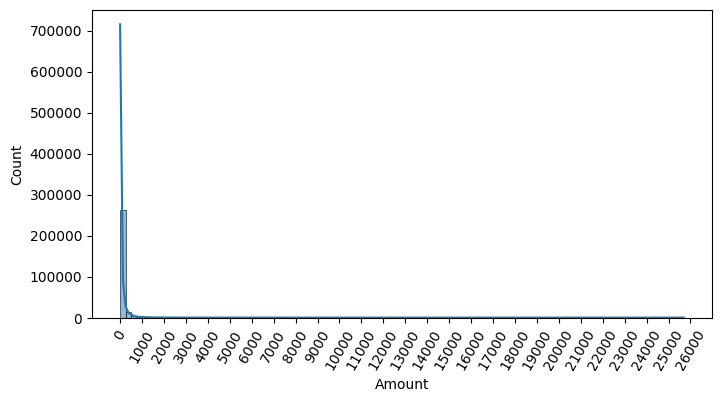

In [25]:
#Amount 피처의 분포도 확인
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation = 60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler
#사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  #변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled', amount_n)
  #기존 Time, Amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace =True)
  return df_copy

In [27]:
#Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 예측 성능###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차 행렬
[[85281    14]
 [   55    93]]
정확도:0.9992, 정밀도: 0.8692, 재현율: 0.6284, f1: 0.7294, AUC:0.9706
### LightGBM 예측 성능###
오차 행렬
[[85290     5]
 [   37   111]]
정확도:0.9995, 정밀도: 0.9569, 재현율: 0.7500, f1: 0.8409, AUC:0.9779


In [28]:
#StandardScaler가 아닌 로그변환 수행 #loglp() 함수 이용
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  #넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
  return df_copy


In [29]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, tgt_train=y_train, tgt_test = y_test)

print('###LightGBM 예측 성능###')

###로지스틱 회귀 예측 성능###
오차 행렬
[[85281    14]
 [   59    89]]
정확도:0.9991, 정밀도: 0.8641, 재현율: 0.6014, f1: 0.7092, AUC:0.9738
###LightGBM 예측 성능###


**이상치 데이터 제거 후 모델 학습/예측/평가**

<Axes: >

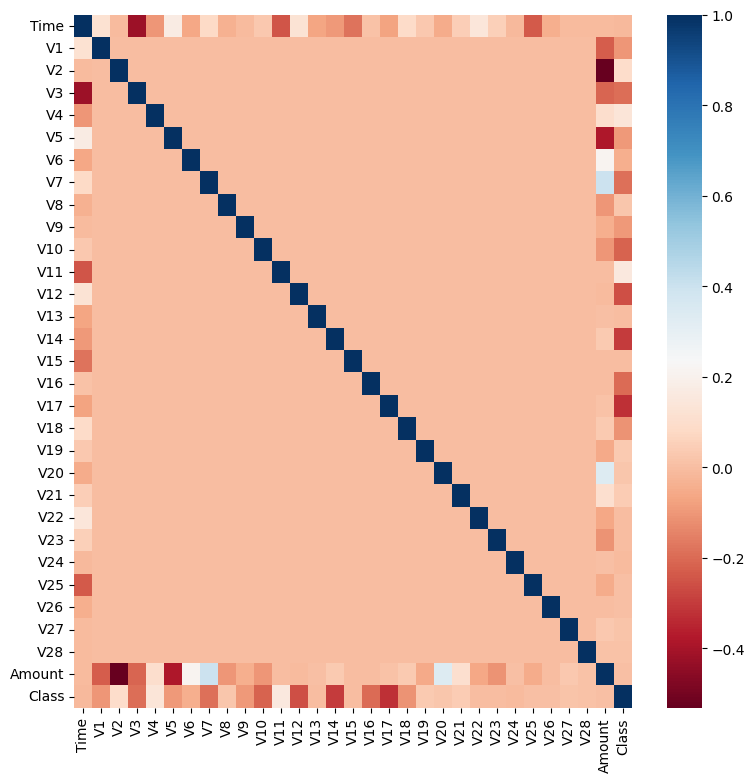

In [30]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

cmap을 'RdBu'로 설정해 양의 상관관계가 높을수록 진한 파란색, 음의 상관관계가 높을수록 색깔이 진한 빨간색
* 맨 아래 위치한 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14, V17

In [31]:
#V14에 대해서만 이상치를 찾아서 제거
import numpy as np

#인자로 DataFrame과 이상치를 검출한 칼럼을 입력받음
def get_outlier(df=None, column=None, weight=1.5):
  #fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점은 np.percentile로 구함
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  #IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr = quantile_75-quantile_25
  iqr_weight = iqr*weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  #최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index = fraud[(fraud<lowest_val)|(fraud > highest_val)].index
  return outlier_index

outlier_index = get_outlier(df=card_df, column = 'V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [33]:
#get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis =1, inplace =True)
  #이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능###
오차 행렬
[[85280    15]
 [   48    98]]
정확도:0.9993, 정밀도: 0.8673, 재현율: 0.6712, f1: 0.7568, AUC:0.9725
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도:0.9996, 정밀도: 0.9603, 재현율: 0.8288, f1: 0.8897, AUC:0.9780


**SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**
* 반드시 학습 데이터 세트만 오버샘플링
* 검증/테스트 데이터 세트를 오버 샘플링할 경우 원본 데이터 세트가 아닌 데이터세트에서 검증/테스트를 수행하기에 올바르지 않음

In [34]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 Class
0    199020
1    199020
Name: count, dtype: int64


In [35]:
#로지스틱 회귀모델을 학습한 뒤 성능 평가
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도:0.9722, 정밀도: 0.0541, 재현율: 0.9247, f1: 0.1022, AUC:0.9736


-> 정밀도가 크게 저하. 현실업무에 적용할 수 X

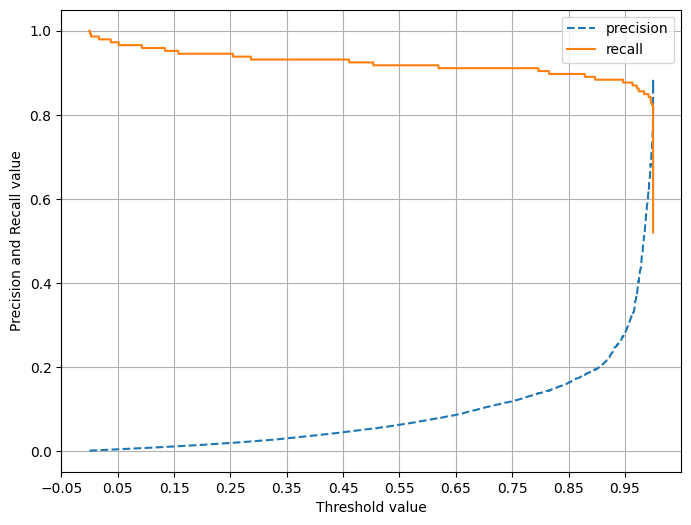

In [37]:
#시각화
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8, 6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label ='recall')

  # threshold 값 X 축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

->올바른 재현율/정밀도 성능을 얻을 수 없음. 로지스틱 회귀 모델의 경우 SMOTE 적용이 올바른 예측 모델X

In [38]:
#LightGBM 모델을 SMOTE로 오버 샘플링
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도:0.9996, 정밀도: 0.9118, 재현율: 0.8493, f1: 0.8794, AUC:0.9814


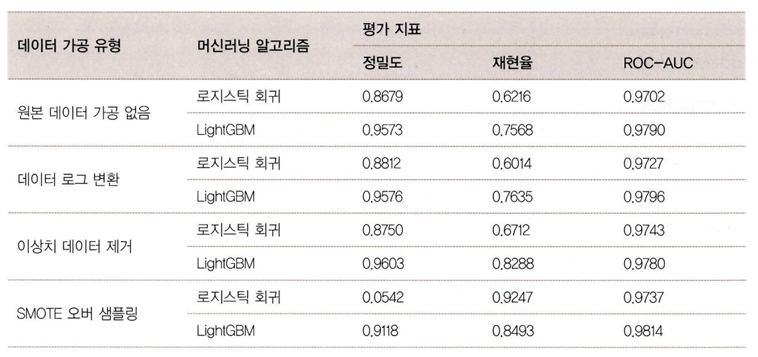

# **스태킹 앙상블**

In [40]:
#위스콘신 암 데이터
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size = 0.2, random_state=0)

In [41]:
#개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0 )
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#개별 모델 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [42]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도:0.9211
랜덤 포레스트 정확도:0.9649
결정 트리 정확도:0.8947
에이다부스트 정확도:0.9737


In [48]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose 이용해 행과 열의 위치 교환
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [50]:
lr_final = LogisticRegression()
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도:0.9649


-> 최종 학습 시 레이블 데이터 세트로 학습 데이터가 아닌 테스트용 레이블 데이터 세트를 기반으로 학습. 과적합 문제 발생할 수 있

**CV 세트 기반의 스태킹**

In [54]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  #지정된 n_folds값으로 KFold 생성
  kf=KFold(n_splits=n_folds, shuffle =False)
  #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    print('\t 폴드 세트: ', folder_counter,'시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr, y_tr)
    train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
    #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균해 테스트 데이터 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [55]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작


concatenate(): 여러 개의 넘파이 배열을 칼럼 또는 로우 레벨로 합쳐주는 기능 제공

In [56]:
#스텝 2 구현
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis = 1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis= 1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [57]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도:0.9737
